In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
IMAGE_H= 150
IMAGE_W=150
BATCH_SIZE = 32
channels = 3
epochs= 50

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"Lung Cancer Images",
    shuffle=True,
    image_size= (IMAGE_H,IMAGE_W),
    batch_size= BATCH_SIZE
)

Found 15000 files belonging to 3 classes.


In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 150, 150, 3)
[0 1 0 1 1 2 0 1 2 2 0 1 0 1 0 0 0 0 0 2 1 0 0 0 2 1 1 1 2 2 1 1]


In [6]:
#70% ==> training
#30% ==> 20% validation, 10% test

In [7]:
train_size = 0.8 # 0.8 is use there because we trained 80% images
len(dataset)*train_size

375.20000000000005

In [8]:
train_ds=dataset.take(422)
len(train_ds)

422

In [9]:
test_ds=dataset.skip(422)
len(test_ds)

47

In [10]:
val_size=0.1
len(dataset)*val_size

46.900000000000006

In [11]:
val_ds=test_ds.take(52)
len(val_ds)

47

In [12]:
test_ds=test_ds.skip(52)
len(test_ds)

0

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle =True, shuffle_size= 10000): 
    assert (train_split + test_split + val_split) == 1

    ds_size=len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed = 12)

    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds= ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(255, 255),
    Rescaling(1.0 / 255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])


In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE,IMAGE_H, IMAGE_W, channels)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

c:\Users\Koushik\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:

# view the structure of the model
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 251, 251, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 125, 125, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 123, 123, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 121, 121, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 60, 60, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 58, 58, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 56, 56, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 28, 28, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 100352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 256)              │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,018,788 (99.25 MB)

 Trainable params: 26,018,788 (99.25 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [23]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [24]:
history=model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)


Epoch 1/50


c:\Users\Koushik\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 ━━━━━━━━━━━━━━━━━━━━ 1137s 3s/step - accuracy: 0.6898 - loss: 0.6318 - val_accuracy: 0.6345 - val_loss: 0.6485
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 891s 2s/step - accuracy: 0.8366 - loss: 0.3956 - val_accuracy: 0.9056 - val_loss: 0.3040
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 889s 2s/step - accuracy: 0.9065 - loss: 0.2362 - val_accuracy: 0.9246 - val_loss: 0.2061
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 890s 2s/step - accuracy: 0.9226 - loss: 0.2015 - val_accuracy: 0.8410 - val_loss: 0.3456
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.9224 - loss: 0.1964 - val_accuracy: 0.9348 - val_loss: 0.1636
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 892s 2s/step - accuracy: 0.9301 - loss: 0.1795 - val_accuracy: 0.9477 - val_loss: 0.1623
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 893s 2s/step - accuracy: 0.9314 - loss: 0.1710 - val_accuracy: 0.9219 - val_loss: 0.1830
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 892s 2s/step - accuracy: 0.9327 - loss: 0.1750 - val_accuracy: 0.95

In [25]:
model.evaluate(test_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 272s 680ms/step - accuracy: 0.9981 - loss: 0.0092


[0.013732905499637127, 0.9967448115348816]

In [26]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

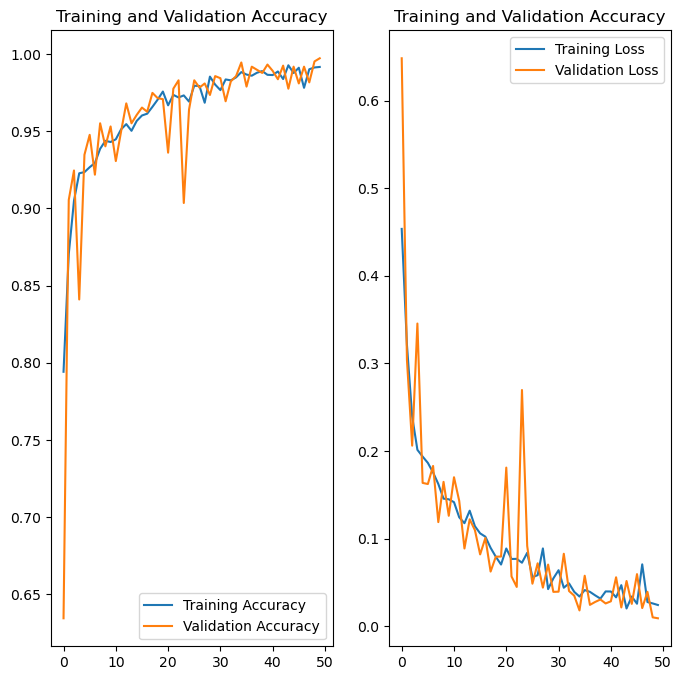

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

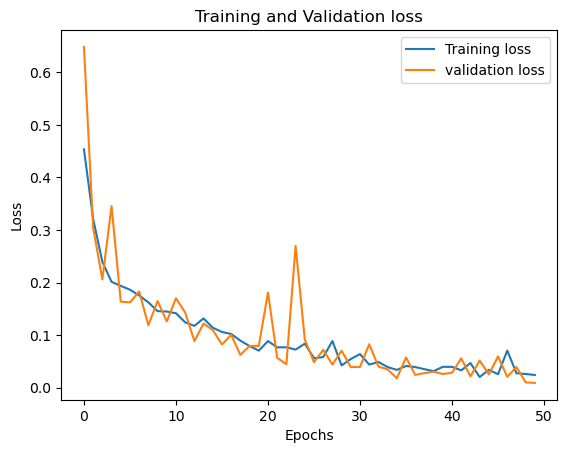

In [30]:
plt.plot(range(epochs), loss,label='Training loss')
plt.plot(range(epochs), val_loss , label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
class_names = dataset.class_names

first image to predict
actual label: Lung-Benign_Tissue
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
predicted label: Lung-Benign_Tissue


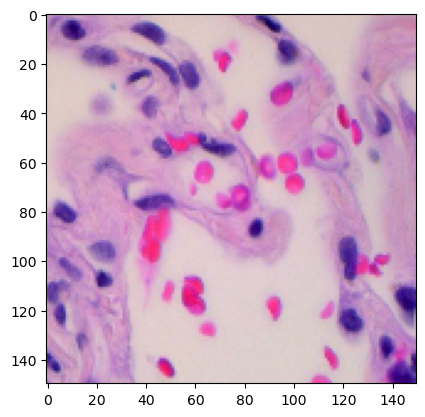

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


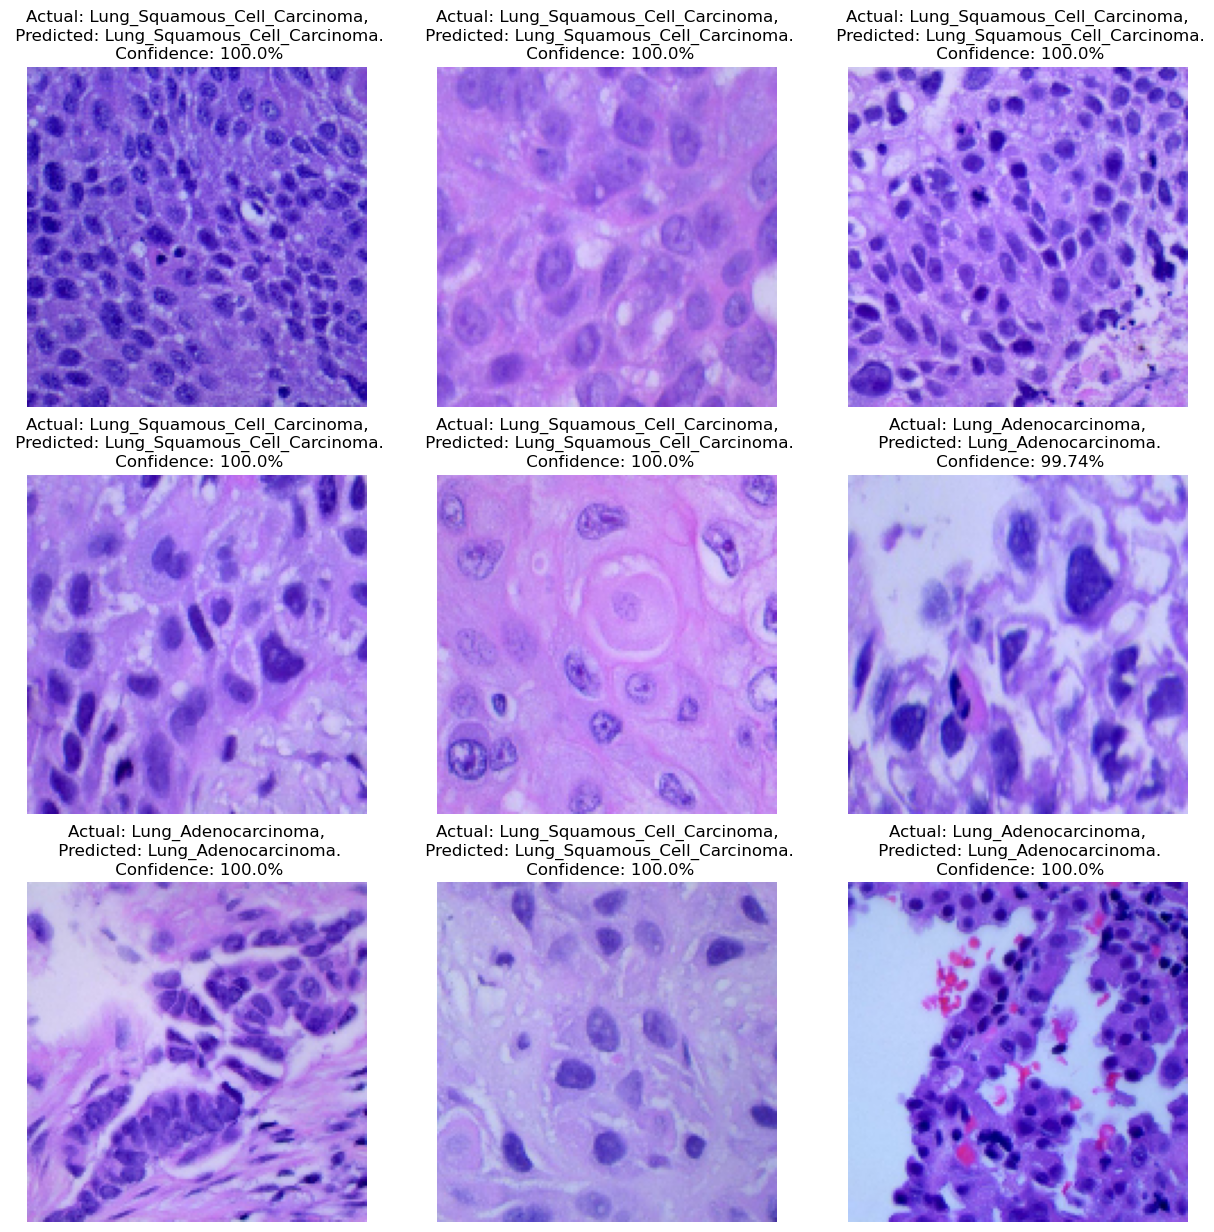

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [35]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [36]:
test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
y_pred = np.argmax(model.predict(test_images), axis=-1)

# get class names and generate and print the classification report and confusion matrix
class_names = dataset.class_names
print("Class Names:", class_names)
print("Classification Report:\n", classification_report(test_labels, y_pred, labels=range(len(class_names)), target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 573ms/step
Class Names: ['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma']
Classification Report:
                               precision    recall  f1-score   support

          Lung-Benign_Tissue       1.00      1.00      1.00       499
         Lung_Adenocarcinoma       1.00      0.99      1.00       528
Lung_Squamous_Cell_Carcinoma       0.99      1.00      1.00       509

                    accuracy                           1.00      1536
                   macro avg       1.00      1.00      1.00      1536
                weighted avg       1.00      1.00      1.00      1536

Confusion Matrix:
 [[498   1   0]
 [  0 524   4]
 [  0   0 509]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma']


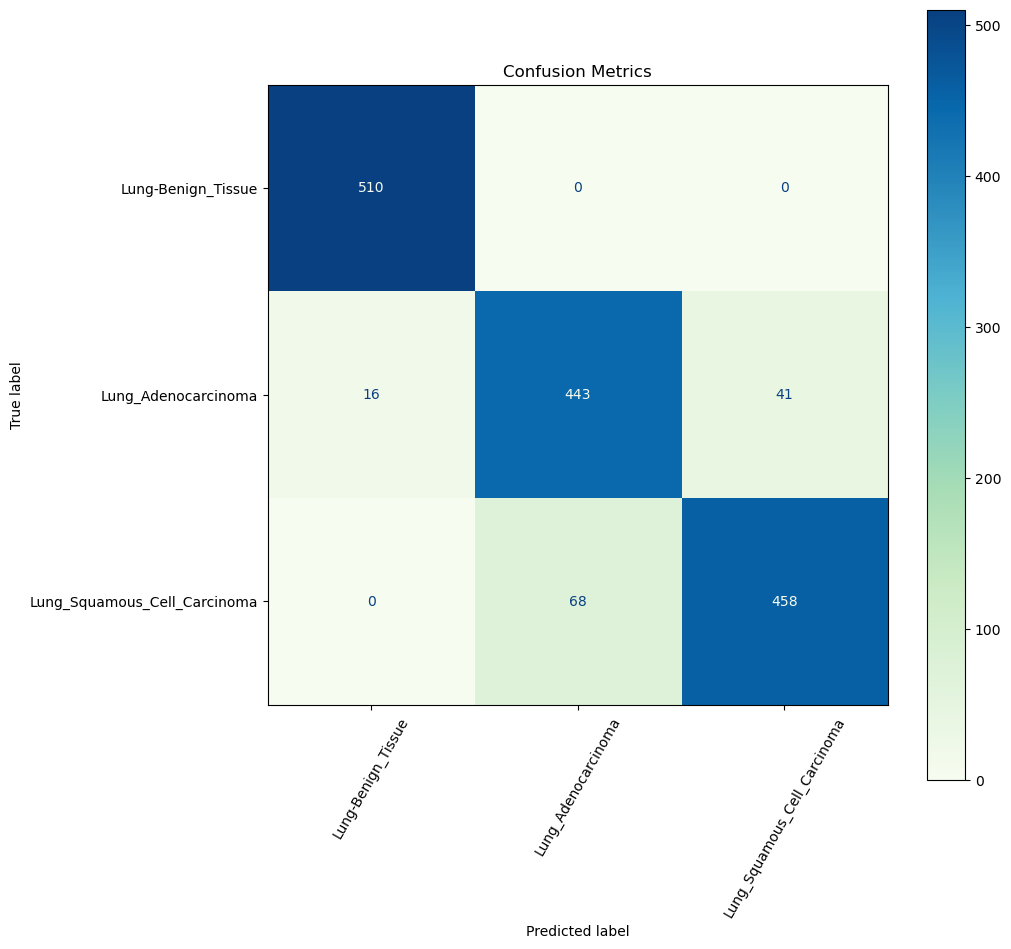

In [ ]:
cm = confusion_matrix(test_labels, y_pred)
display_c_m = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
display_c_m.plot(cmap='GnBu',ax=ax,xticks_rotation=60)
plt.title("Confusion Metrics")
plt.show()

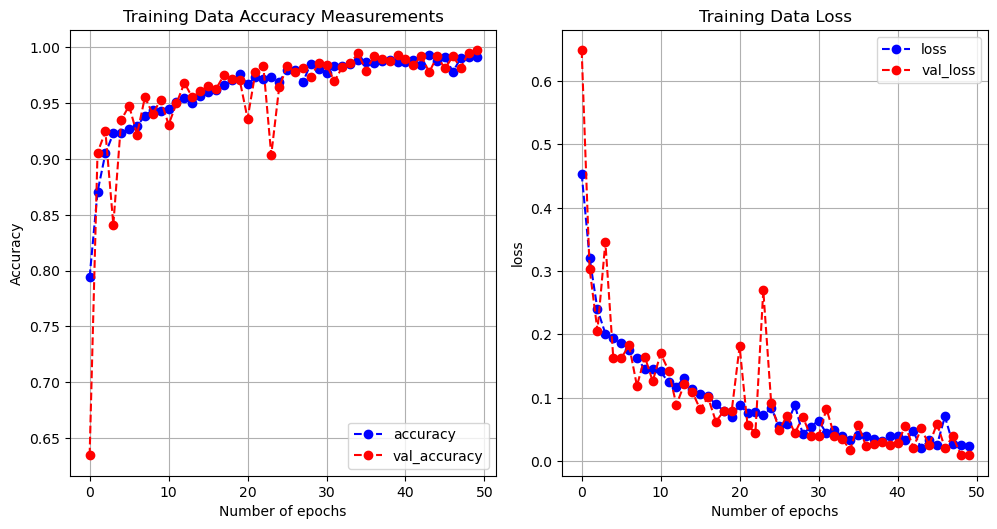

In [37]:
def acc_loss_plot(history):
    fig = plt.figure(figsize=(15,10))

    plt.subplot(231)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()


    plt.subplot(232)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.show()
acc_loss_plot(history)

In [2]:
def accuracy(history):
    fig = plt.figure(figsize=(7,7))


    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
accuracy(history)

NameError: name 'history' is not defined

In [39]:
from sklearn.metrics import roc_curve, auc
import numpy as np


In [40]:
print (n_classes)

4


In [41]:
print(y_pred)

[1 0 1 ... 2 1 0]


In [42]:
y_pred = model.predict(test_ds)  # This will give probabilities for each class

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step


In [43]:
n_classes = len(np.unique(test_labels))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    y_true = (test_labels == i).astype(int)
    y_score = y_pred[:, i]  # Access the probabilities for class `i`
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

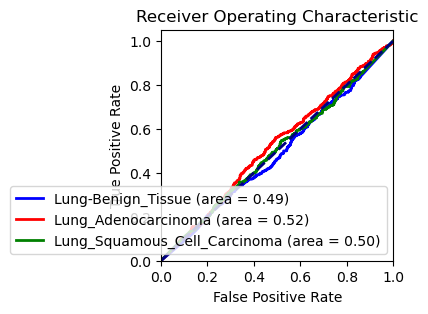

In [44]:
plt.figure(figsize=(3, 3))
colors = ['blue', 'red', 'green', 'purple', 'orange','yellow']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{} (area = {:.2f})'.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve, average_precision_score

# generate predictions on the test set
test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
y_pred = model.predict(test_images)

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step


48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 747ms/step


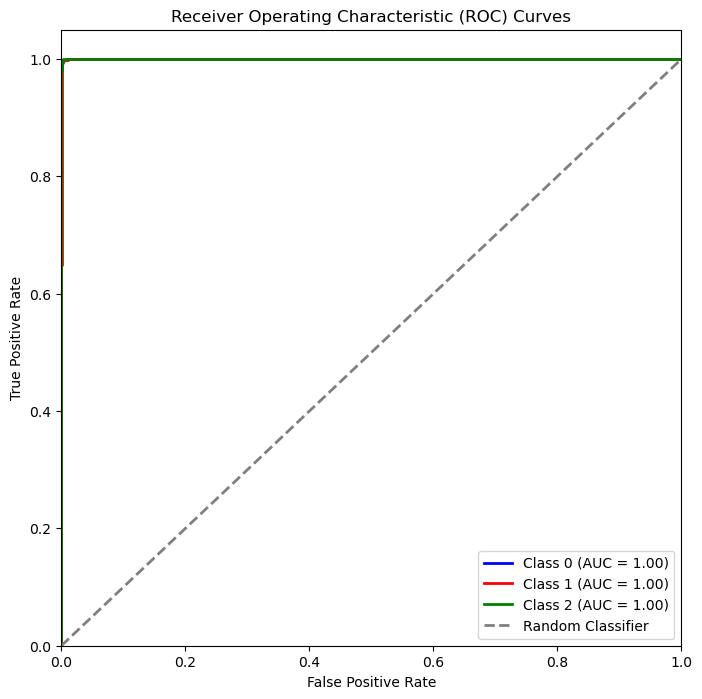

In [46]:
# calculate ROC curve and AUC for each class separately
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `n_classes` is the number of classes in your model
n_classes = len(np.unique(test_labels))  
class_names = [f'Class {i}' for i in range(n_classes)]  # Replace with actual class names if available

# Binarize the test labels for multi-class ROC
test_labels_binarized = label_binarize(test_labels, classes=np.arange(n_classes))

# Predict probabilities for each class
y_pred = model.predict(test_images)

# Initialize dictionaries to store False Positive Rate, True Positive Rate, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow']
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 773ms/step


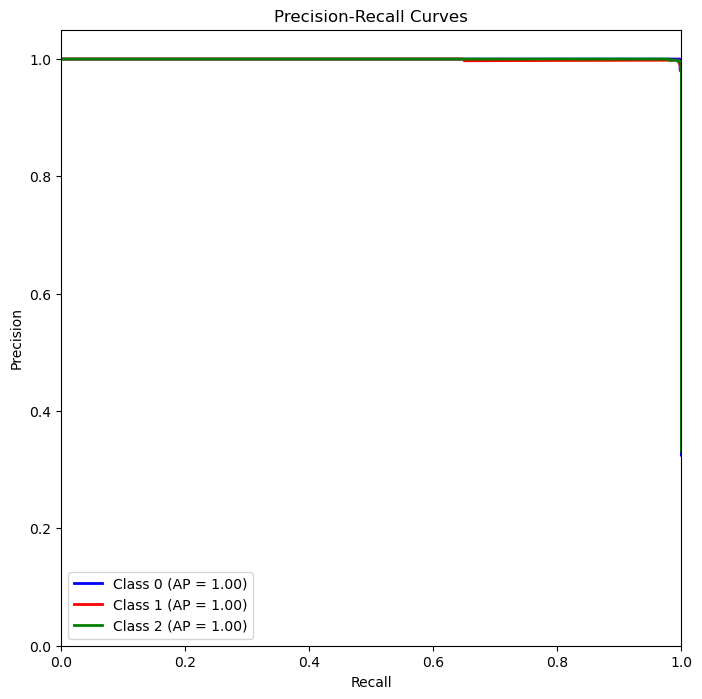

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class Precision-Recall analysis
test_labels_binarized = label_binarize(test_labels, classes=np.arange(n_classes))

# Calculate predicted probabilities for each class
y_pred = model.predict(test_images)

# Initialize dictionaries to store precision, recall, and average precision (AP) for each class
precision = dict()
recall = dict()
average_precision = dict()

# Calculate Precision-Recall and Average Precision (AP) for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_binarized[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(test_labels_binarized[:, i], y_pred[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow']
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='{} (AP = {:.2f})'.format(class_names[i], average_precision[i]))

# Customize plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


In [48]:
print('Average AUC: {:.3f}'.format(np.mean(list(roc_auc.values()))))

Average AUC: 1.000


In [49]:
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [50]:
model_version = 2

In [51]:
import os

# Ensure the directory exists
os.makedirs("../models", exist_ok=True)

# Now save the model
model.save(f"../models/{model_version}.keras")

In [52]:
model.save('My_New_Lung_Cancer_Data_File.h5')